In [71]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor

In [2]:
import tensorflow as tf

In [3]:
directory_path = 'C:\Python\Fah'
dfs = []
for filename in os.listdir(directory_path):
    if filename.endswith('2022.csv'):
        with open(os.path.join(directory_path, filename)) as f:
            first_row = f.readline().strip().split(',')
        state = first_row[0]
        df = pd.read_csv(os.path.join(directory_path, filename), skiprows=4)
        df['State'] = state
        dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,Date,Value,Anomaly,State
0,189501,43.1,-2.0,Alabama
1,189502,37.4,-10.6,Alabama
2,189503,54.5,-0.6,Alabama
3,189504,63.4,0.5,Alabama
4,189505,69.5,-1.2,Alabama
...,...,...,...,...
74360,202109,73.8,-0.7,Georgia
74361,202110,67.3,3.0,Georgia
74362,202111,52.8,-1.4,Georgia
74363,202112,56.6,9.5,Georgia


In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74365 entries, 0 to 74364
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     74365 non-null  int64  
 1   Value    74365 non-null  float64
 2   Anomaly  74365 non-null  float64
 3   State    74365 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
combined_df['Date'] = combined_df['Date'].astype(str)
combined_df['Year'] = combined_df['Date'].str[:4]
combined_df['Month'] = combined_df['Date'].str[4:]  
combined_df['Date'] = combined_df['Year'] + '-' + combined_df['Month']
combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%Y-%m').dt.to_period('M')

# Average Temperature seasonal trend

Randomly selecting 3 states and plotting the trend

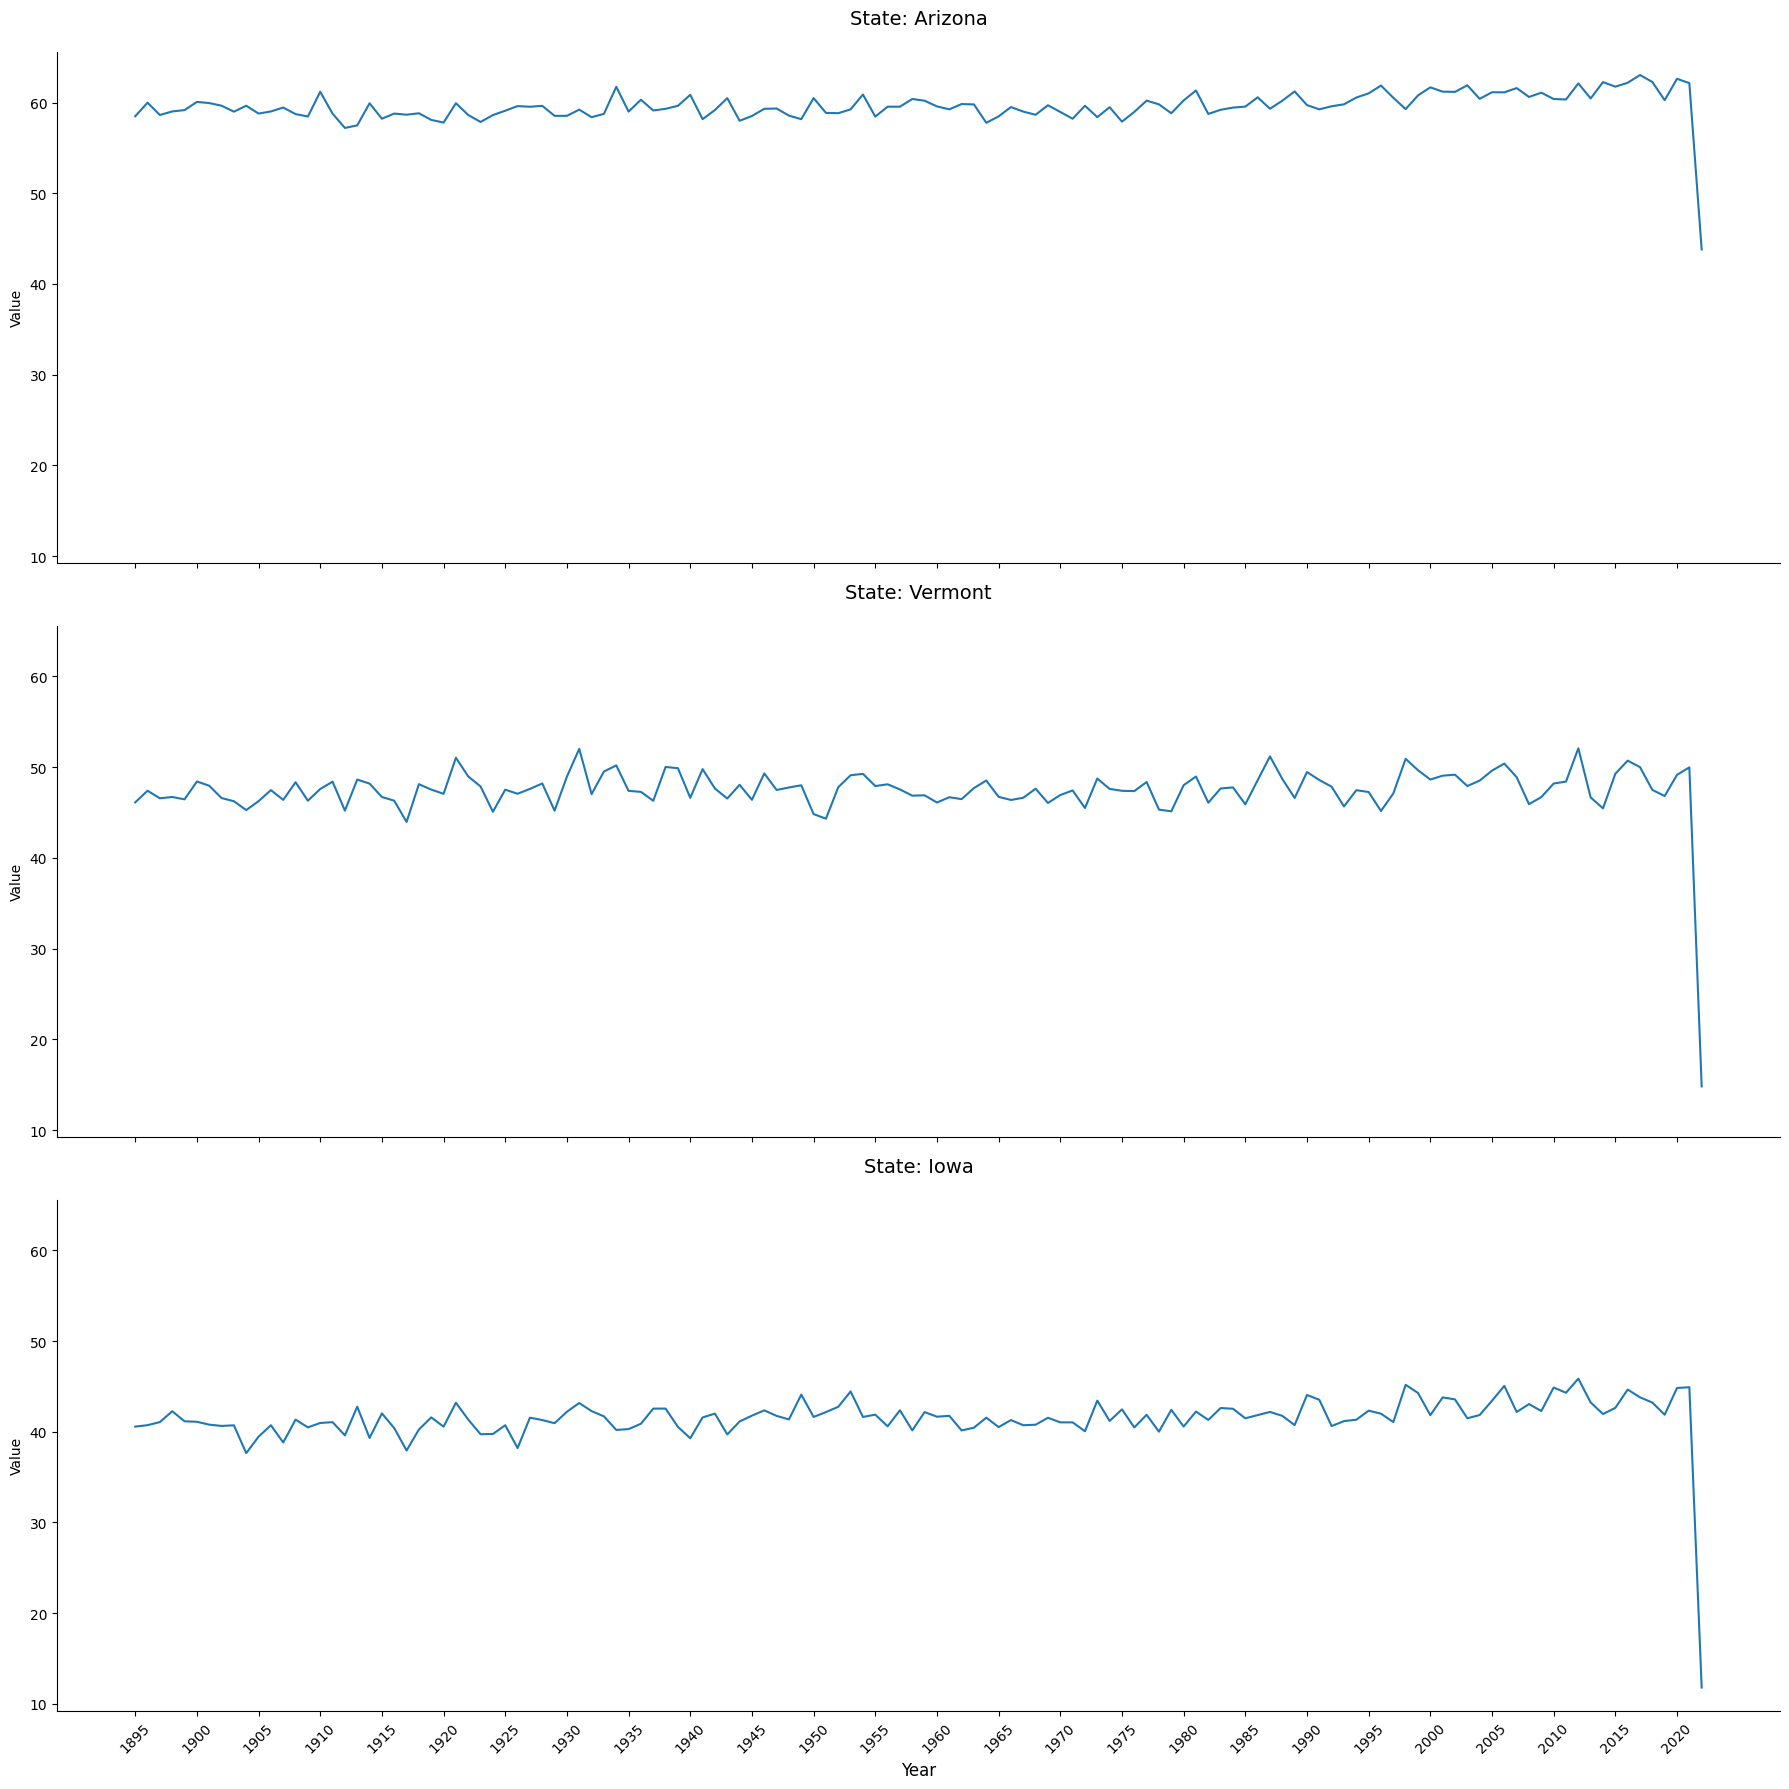

In [8]:
temp_by_state = combined_df.groupby(['State', 'Year'])['Value'].mean().reset_index()
states_to_plot = np.random.choice(temp_by_state['State'].unique(), size=3, replace=False)
temp_by_state = temp_by_state[temp_by_state['State'].isin(states_to_plot)]
g = sns.FacetGrid(temp_by_state, col='State', col_wrap=1, height=6, aspect=3)
g.map(sns.lineplot, 'Year', 'Value')
g.set_xlabels('Year', fontsize=12)
for ax in g.axes.flat:
    ax.set_xticks(temp_by_state['Year'].unique()[::5])
    ax.set_xticklabels(temp_by_state['Year'].unique()[::5])
for ax in g.axes.flat[-5:]:
    ax.tick_params(axis='x', rotation=45, labelsize=10)
for ax, title in zip(g.axes.flat, states_to_plot):
    ax.set_title('State: {}'.format(title), fontsize=14, pad=20)
g.tight_layout()

In [9]:
combined_df2 = combined_df.copy()

# Forecasting the average temperature for all the states

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
combined_df2.set_index('Date', inplace=True)

combined_df2['Value'] = pd.to_numeric(combined_df2['Value'])

state_dfs = {state: combined_df2[combined_df2['State']==state].copy() for state in combined_df2['State'].unique()}


for state in state_dfs:
    train = state_dfs[state].iloc[:-500] 
    test = state_dfs[state].iloc[-500:]
    model = SARIMAX(train['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit()
    state_dfs[state]['Forecast'] = results.predict(start=test.index[0], end=test.index[-1])
    

df_forecast = pd.concat(state_dfs.values())
df_forecast.reset_index(inplace=True)

print(df_forecast)


          Date  Value  Anomaly    State  Year Month   Forecast
0      1895-01   43.1     -2.0  Alabama  1895    01        NaN
1      1895-02   37.4    -10.6  Alabama  1895    02        NaN
2      1895-03   54.5     -0.6  Alabama  1895    03        NaN
3      1895-04   63.4      0.5  Alabama  1895    04        NaN
4      1895-05   69.5     -1.2  Alabama  1895    05        NaN
...        ...    ...      ...      ...   ...   ...        ...
74360  2021-09   73.8     -0.7  Georgia  2021    09  73.281669
74361  2021-10   67.3      3.0  Georgia  2021    10  62.908260
74362  2021-11   52.8     -1.4  Georgia  2021    11  52.994930
74363  2021-12   56.6      9.5  Georgia  2021    12  45.958355
74364  2022-01   45.9     -0.2  Georgia  2022    01  44.582857

[74365 rows x 7 columns]


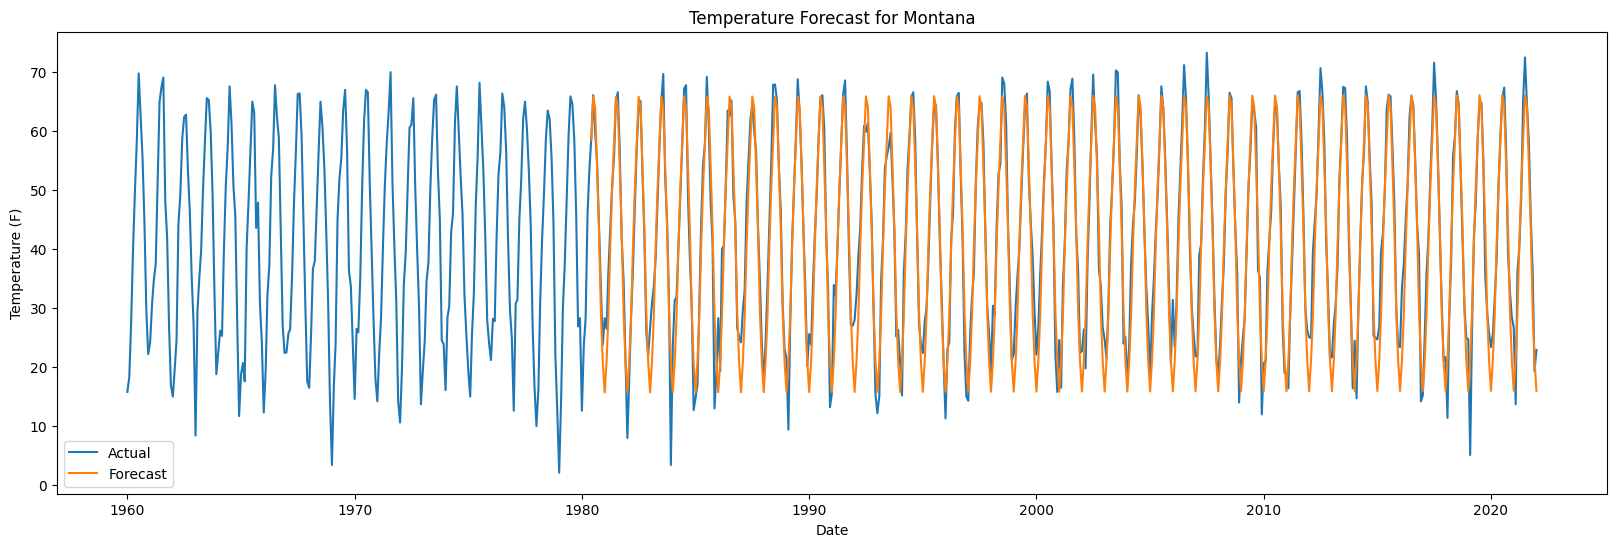

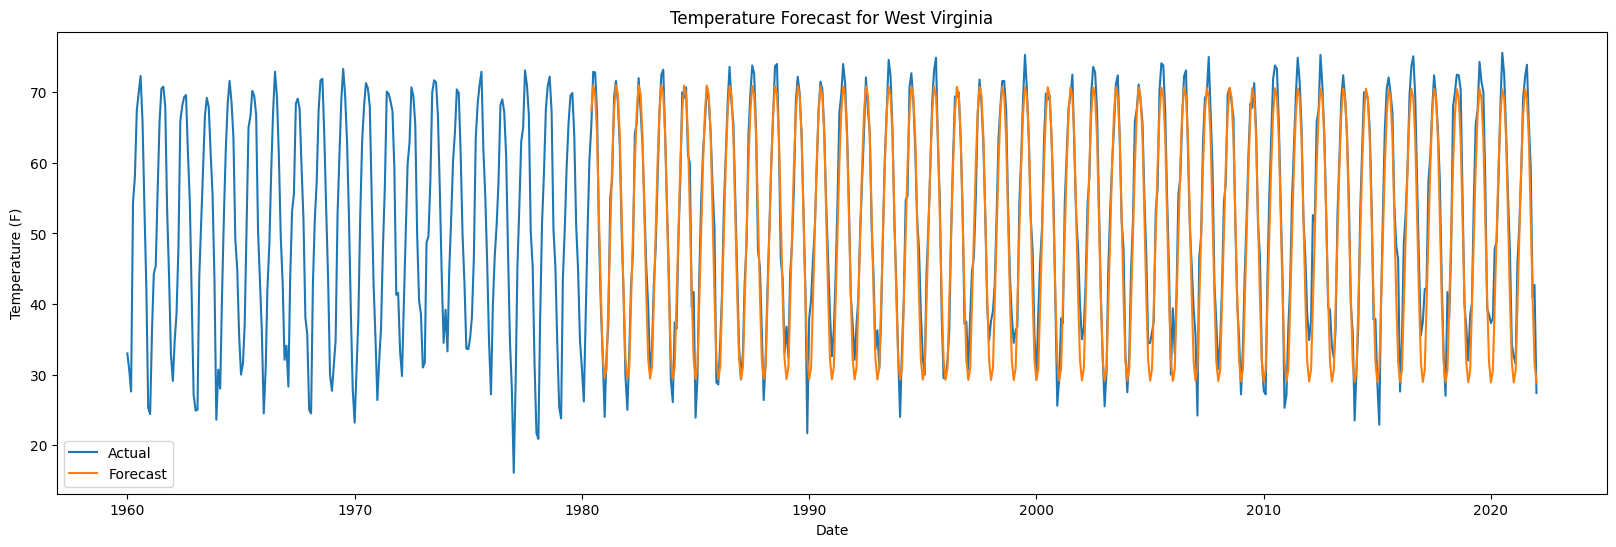

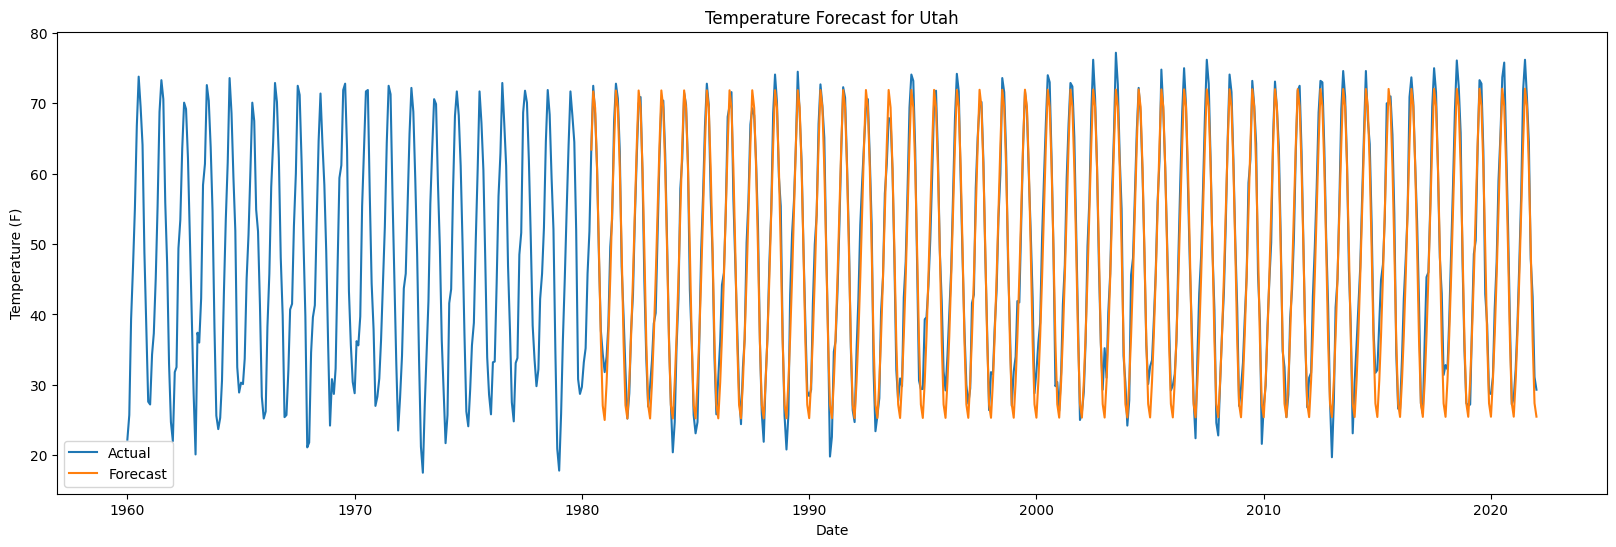

In [11]:
states = df_forecast['State'].unique()
random_states = random.sample(list(states), 3)
for state in random_states:
    state_df = df_forecast[df_forecast['State']==state]
    state_df = state_df.loc[state_df['Date'].dt.year >= 1960] 
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Value'], label='Actual')
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Forecast'], label='Forecast')
    ax.set_title(f'Temperature Forecast for {state}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (F)')
    ax.legend()
    plt.show()

In [12]:
df_forecast2 = df_forecast.copy()

In [13]:
import pandas as pd

start_date = df_forecast2['Date'].max().start_time.to_pydatetime()
end_date = start_date + pd.DateOffset(years=10)
date_range = pd.date_range(start=start_date + pd.DateOffset(months=1), end=end_date, freq='MS').strftime('%Y-%m').tolist()

states = df_forecast2['State'].unique().tolist()

state_dfs = []

for state in states:
    state_df = pd.DataFrame({'Date': date_range, 'State': state})
    state_df['Date'] = pd.to_datetime(state_df['Date'])
    state_dfs.append(state_df)

new_df = pd.concat(state_dfs, ignore_index=True)

new_df = pd.merge(new_df, df_forecast2, on=['Date', 'State'], how='left')


In [14]:
new_df['Date'] = pd.to_datetime(new_df['Date'], format='%Y-%m')
new_df['Date'] = new_df['Date'].dt.to_period('M')

df_forecast2 = pd.concat([df_forecast2, new_df], axis=0, join='outer')

df_forecast2 = df_forecast2.sort_values(['State', 'Date']).reset_index(drop=True)

In [15]:
df_forecast2

,Date,Value,Anomaly,State,Year,Month,Forecast
0,1895-01,43.1,-2.0,Alabama,1895,01,NaN
1,1895-02,37.4,-10.6,Alabama,1895,02,NaN
2,1895-03,54.5,-0.6,Alabama,1895,03,NaN
3,1895-04,63.4,0.5,Alabama,1895,04,NaN
4,1895-05,69.5,-1.2,Alabama,1895,05,NaN
...,...,...,...,...,...,...,...
80240,2031-09,NaN,NaN,Wyoming,NaN,NaN,NaN
80241,2031-10,NaN,NaN,Wyoming,NaN,NaN,NaN
80242,2031-11,NaN,NaN,Wyoming,NaN,NaN,NaN
80243,2031-12,NaN,NaN,Wyoming,NaN,NaN,NaN


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df_forecast2.set_index('Date', inplace=True)

df_forecast2['Value'] = pd.to_numeric(df_forecast2['Value'])

state_dfs = {state: df_forecast2[df_forecast2['State']==state].copy() for state in df_forecast2['State'].unique()}

for state in state_dfs:
    train = state_dfs[state].iloc[:-120] 
    test = state_dfs[state].iloc[-120:]
    model = SARIMAX(train['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit()
    state_dfs[state]['Forecast'] = results.predict(start=test.index[0], end=test.index[-1])
df_forecast3 = pd.concat(state_dfs.values())
df_forecast3.reset_index(inplace=True)

print(df_forecast3)


          Date  Value  Anomaly    State  Year Month   Forecast
0      1895-01   43.1     -2.0  Alabama  1895    01        NaN
1      1895-02   37.4    -10.6  Alabama  1895    02        NaN
2      1895-03   54.5     -0.6  Alabama  1895    03        NaN
3      1895-04   63.4      0.5  Alabama  1895    04        NaN
4      1895-05   69.5     -1.2  Alabama  1895    05        NaN
...        ...    ...      ...      ...   ...   ...        ...
80240  2031-09    NaN      NaN  Wyoming   NaN   NaN  56.250110
80241  2031-10    NaN      NaN  Wyoming   NaN   NaN  43.798926
80242  2031-11    NaN      NaN  Wyoming   NaN   NaN  31.703353
80243  2031-12    NaN      NaN  Wyoming   NaN   NaN  22.658771
80244  2032-01    NaN      NaN  Wyoming   NaN   NaN  22.229033

[80245 rows x 7 columns]


In [17]:
df_forecast3

,Date,Value,Anomaly,State,Year,Month,Forecast
0,1895-01,43.1,-2.0,Alabama,1895,01,NaN
1,1895-02,37.4,-10.6,Alabama,1895,02,NaN
2,1895-03,54.5,-0.6,Alabama,1895,03,NaN
3,1895-04,63.4,0.5,Alabama,1895,04,NaN
4,1895-05,69.5,-1.2,Alabama,1895,05,NaN
...,...,...,...,...,...,...,...
80240,2031-09,NaN,NaN,Wyoming,NaN,NaN,56.250110
80241,2031-10,NaN,NaN,Wyoming,NaN,NaN,43.798926
80242,2031-11,NaN,NaN,Wyoming,NaN,NaN,31.703353
80243,2031-12,NaN,NaN,Wyoming,NaN,NaN,22.658771


In [18]:
forecasts = pd.concat([df_forecast, df_forecast3], axis=0, join='outer')
forecasts = forecasts.sort_values(['State', 'Date']).reset_index(drop=True)

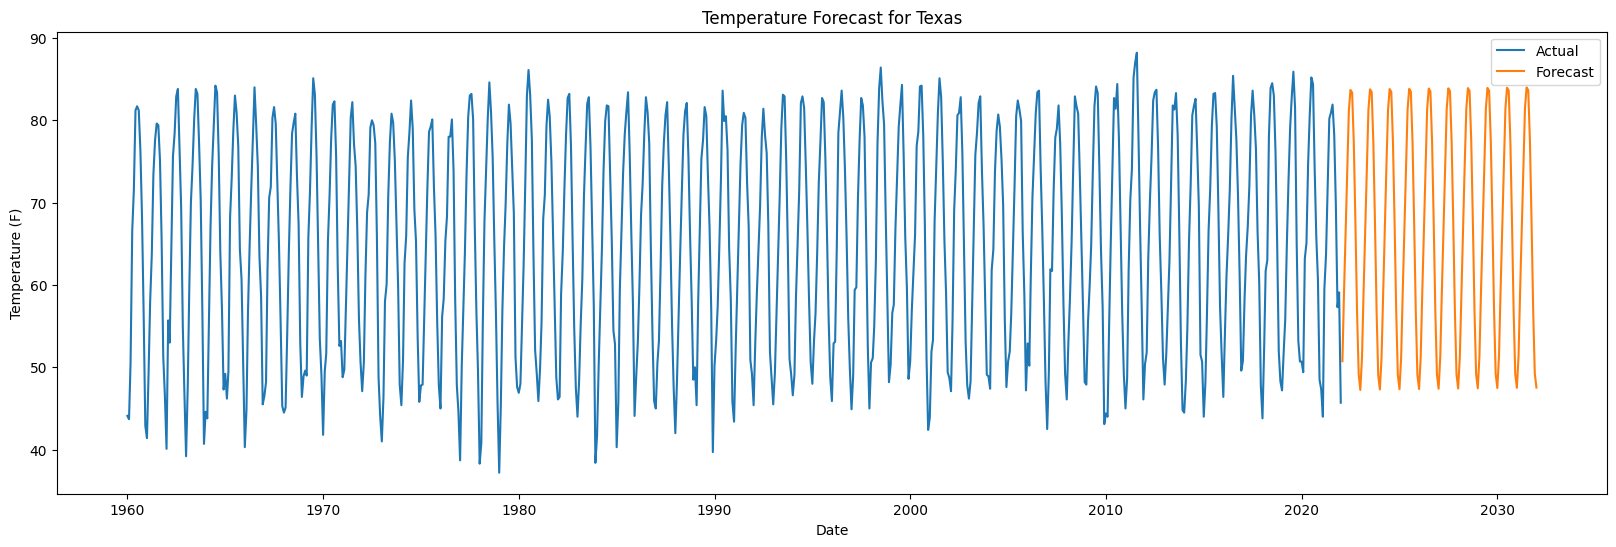

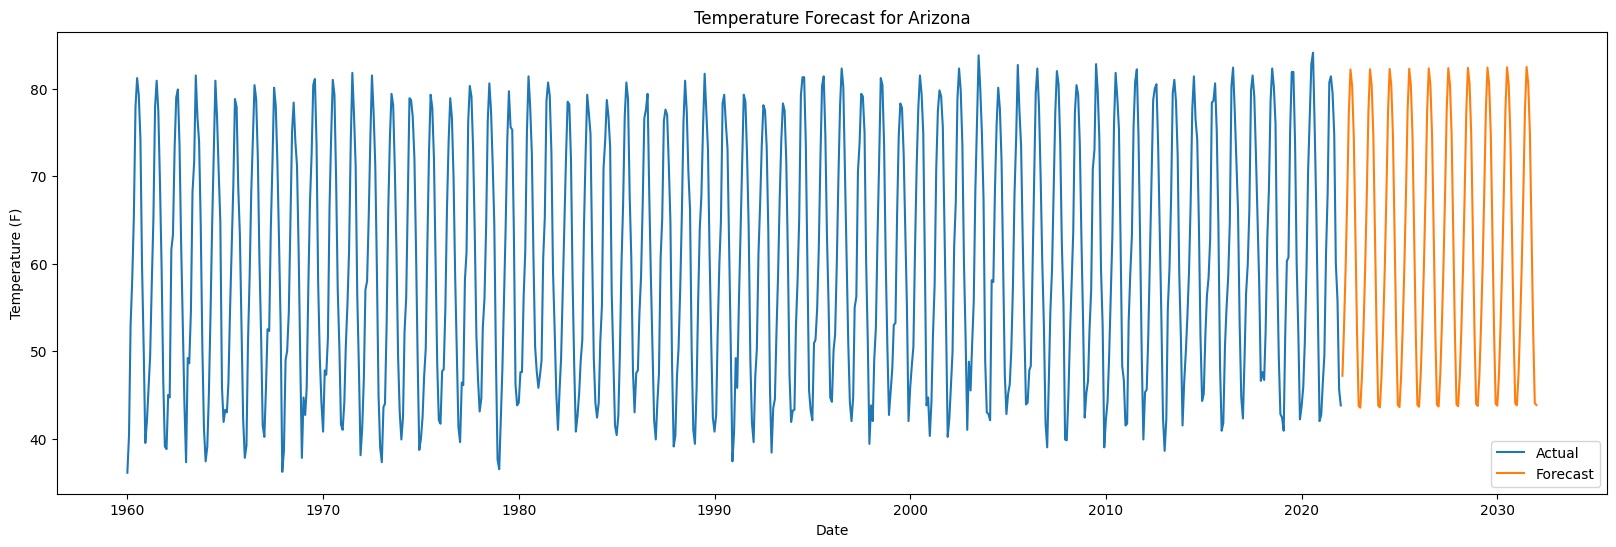

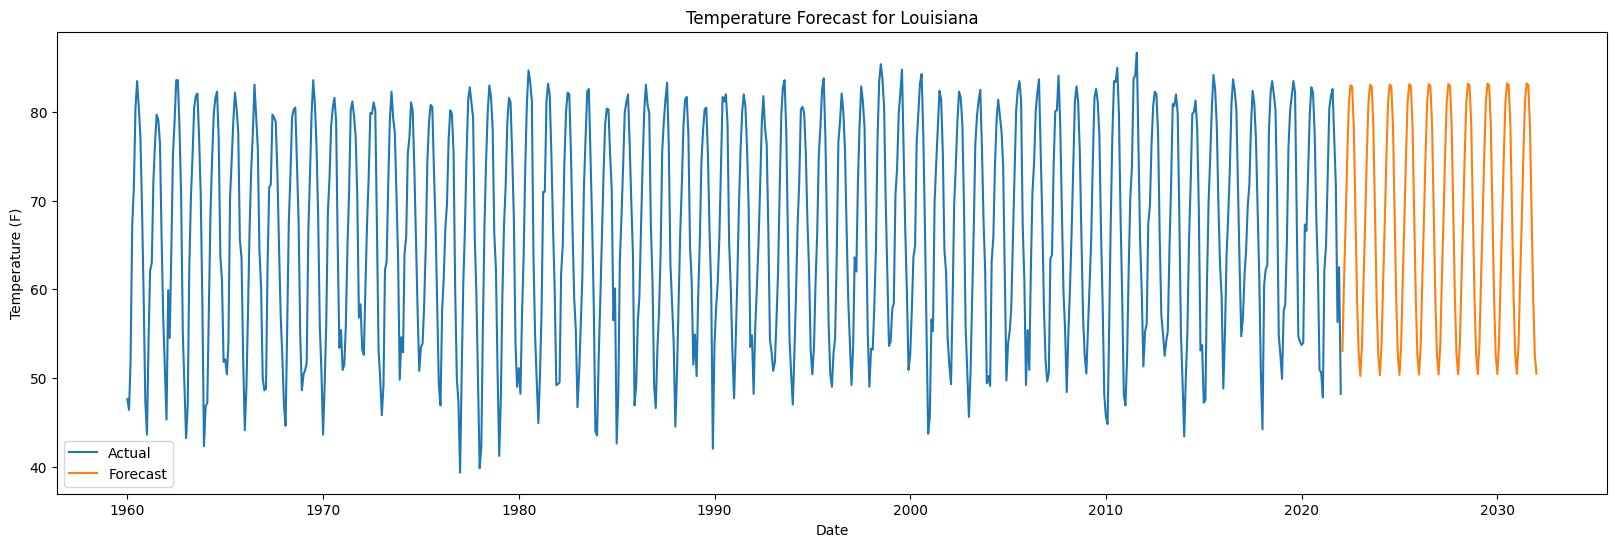

In [19]:
states = forecasts['State'].unique()
random_states = random.sample(list(states), 3)
for state in random_states:
    state_df = forecasts[forecasts['State']==state]
    state_df = state_df.loc[state_df['Date'].dt.year >= 1960]  # Filter data from 1960 onwards
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Value'], label='Actual')
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Forecast'], label='Forecast')
    ax.set_title(f'Temperature Forecast for {state}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (F)')
    ax.legend()
    plt.show()

In [20]:
forecasts

,Date,Value,Anomaly,State,Year,Month,Forecast
0,1895-01,43.1,-2.0,Alabama,1895,01,NaN
1,1895-01,43.1,-2.0,Alabama,1895,01,NaN
2,1895-02,37.4,-10.6,Alabama,1895,02,NaN
3,1895-02,37.4,-10.6,Alabama,1895,02,NaN
4,1895-03,54.5,-0.6,Alabama,1895,03,NaN
...,...,...,...,...,...,...,...
154605,2031-09,NaN,NaN,Wyoming,NaN,NaN,56.250110
154606,2031-10,NaN,NaN,Wyoming,NaN,NaN,43.798926
154607,2031-11,NaN,NaN,Wyoming,NaN,NaN,31.703353
154608,2031-12,NaN,NaN,Wyoming,NaN,NaN,22.658771


In [21]:
forecast1 = forecasts.copy()

In [22]:
forecast1['Date'] = forecast1['Date'].dt.to_timestamp()
df_annual = forecast1.groupby('State').resample('Y', on='Date').mean()
df_annual = df_annual.reset_index()
df_annual['Date'] = df_annual['Date'].dt.year
df_annual






,State,Date,Value,Anomaly,Forecast
0,Alabama,1895,61.641667,-1.450000,NaN
1,Alabama,1896,64.266667,1.175000,NaN
2,Alabama,1897,64.191667,1.100000,NaN
3,Alabama,1898,62.983333,-0.108333,NaN
4,Alabama,1899,63.100000,0.008333,NaN
...,...,...,...,...,...
6727,Wyoming,2028,NaN,NaN,43.031502
6728,Wyoming,2029,NaN,NaN,43.064832
6729,Wyoming,2030,NaN,NaN,43.098161
6730,Wyoming,2031,NaN,NaN,43.131491


In [23]:
df_annual

,State,Date,Value,Anomaly,Forecast
0,Alabama,1895,61.641667,-1.450000,NaN
1,Alabama,1896,64.266667,1.175000,NaN
2,Alabama,1897,64.191667,1.100000,NaN
3,Alabama,1898,62.983333,-0.108333,NaN
4,Alabama,1899,63.100000,0.008333,NaN
...,...,...,...,...,...
6727,Wyoming,2028,NaN,NaN,43.031502
6728,Wyoming,2029,NaN,NaN,43.064832
6729,Wyoming,2030,NaN,NaN,43.098161
6730,Wyoming,2031,NaN,NaN,43.131491


# Precipitation

In [24]:
directory_path = 'C:\Python\pcp1'
dfs = []
for filename in os.listdir(directory_path):
    if filename.endswith('2022.csv'):
        with open(os.path.join(directory_path, filename)) as f:
            first_row = f.readline().strip().split(',')
        state = first_row[0]
        df = pd.read_csv(os.path.join(directory_path, filename), skiprows=4)
        df['State'] = state
        dfs.append(df)
pcp = pd.concat(dfs, ignore_index=True)
pcp

,Date,Value,Anomaly,State
0,189501,7.52,2.36,Alabama
1,189502,2.66,-2.55,Alabama
2,189503,7.62,1.46,Alabama
3,189504,3.58,-1.26,Alabama
4,189505,3.78,-0.45,Alabama
...,...,...,...,...
74360,202109,5.52,1.61,Georgia
74361,202110,4.45,1.71,Georgia
74362,202111,1.13,-1.74,Georgia
74363,202112,4.24,0.16,Georgia


In [25]:
pcp['Date'] = pcp['Date'].astype(str)
pcp['Year'] = pcp['Date'].str[:4]
pcp['Month'] = pcp['Date'].str[4:]  
pcp['Date'] = pcp['Year'] + '-' + pcp['Month']
pcp['Date'] = pd.to_datetime(pcp['Date'], format='%Y-%m').dt.to_period('M')

In [26]:
pcp['temp'] = combined_df['Value']

In [27]:
pcp

,Date,Value,Anomaly,State,Year,Month,temp
0,1895-01,7.52,2.36,Alabama,1895,01,43.1
1,1895-02,2.66,-2.55,Alabama,1895,02,37.4
2,1895-03,7.62,1.46,Alabama,1895,03,54.5
3,1895-04,3.58,-1.26,Alabama,1895,04,63.4
4,1895-05,3.78,-0.45,Alabama,1895,05,69.5
...,...,...,...,...,...,...,...
74360,2021-09,5.52,1.61,Georgia,2021,09,73.8
74361,2021-10,4.45,1.71,Georgia,2021,10,67.3
74362,2021-11,1.13,-1.74,Georgia,2021,11,52.8
74363,2021-12,4.24,0.16,Georgia,2021,12,56.6


In [28]:
pcp2 = pcp.copy()

In [29]:
pcp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74365 entries, 0 to 74364
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype    
---  ------   --------------  -----    
 0   Date     74365 non-null  period[M]
 1   Value    74365 non-null  float64  
 2   Anomaly  74365 non-null  float64  
 3   State    74365 non-null  object   
 4   Year     74365 non-null  object   
 5   Month    74365 non-null  object   
 6   temp     74365 non-null  float64  
dtypes: float64(3), object(3), period[M](1)
memory usage: 4.0+ MB


In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
pcp2.set_index('Date', inplace=True)
pcp2['Value'] = pd.to_numeric(pcp2['Value'])
pcp2['temp'] = pd.to_numeric(pcp2['temp'])
state_dfs = {state: pcp2[pcp2['State']==state].copy() for state in pcp2['State'].unique()}
for state in state_dfs:
    train = state_dfs[state].iloc[:-299]
    test = state_dfs[state].iloc[-299:] 
    train['lagged_precipitation'] = train['Value'].shift(1)
    train['lagged_temperature'] = train['temp'].shift(1)
    train['lagged_precipitation'] = train['lagged_precipitation'].fillna(0)
    train['lagged_temperature'] = train['lagged_temperature'].fillna(0)
    test['lagged_precipitation'] = test['Value'].shift(1)
    test['lagged_temperature'] = test['temp'].shift(1)
    test['lagged_precipitation'] = test['lagged_precipitation'].fillna(0)
    test['lagged_temperature'] = test['lagged_temperature'].fillna(0)
    exog_train = train[['temp', 'lagged_precipitation','lagged_temperature']].values
    exog_test = test[['temp', 'lagged_precipitation','lagged_temperature']].values
    model = SARIMAX(train['Value'],exog=exog_train, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))
    results = model.fit()
    state_dfs[state]['Forecast'] = results.predict(start=test.index[0], end=test.index[-1],exog=exog_test)
df_forecast_pcp = pd.concat(state_dfs.values())
df_forecast_pcp.reset_index(inplace=True)
print(df_forecast_pcp)


C:\Python\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.

          Date  Value  Anomaly    State  Year Month  temp  Forecast
0      1895-01   7.52     2.36  Alabama  1895    01  43.1       NaN
1      1895-02   2.66    -2.55  Alabama  1895    02  37.4       NaN
2      1895-03   7.62     1.46  Alabama  1895    03  54.5       NaN
3      1895-04   3.58    -1.26  Alabama  1895    04  63.4       NaN
4      1895-05   3.78    -0.45  Alabama  1895    05  69.5       NaN
...        ...    ...      ...      ...   ...   ...   ...       ...
74360  2021-09   5.52     1.61  Georgia  2021    09  73.8  3.866783
74361  2021-10   4.45     1.71  Georgia  2021    10  67.3  2.818826
74362  2021-11   1.13    -1.74  Georgia  2021    11  52.8  3.185276
74363  2021-12   4.24     0.16  Georgia  2021    12  56.6  3.310352
74364  2022-01   3.99    -0.38  Georgia  2022    01  45.9  4.442692

[74365 rows x 8 columns]


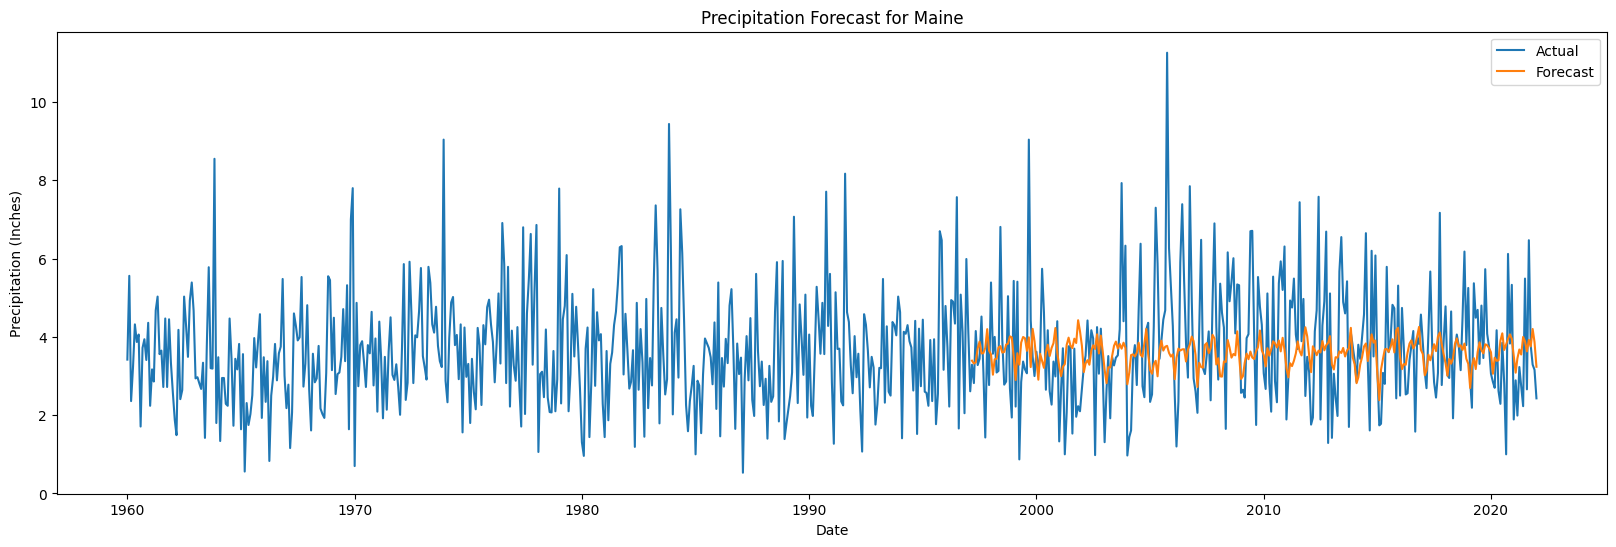

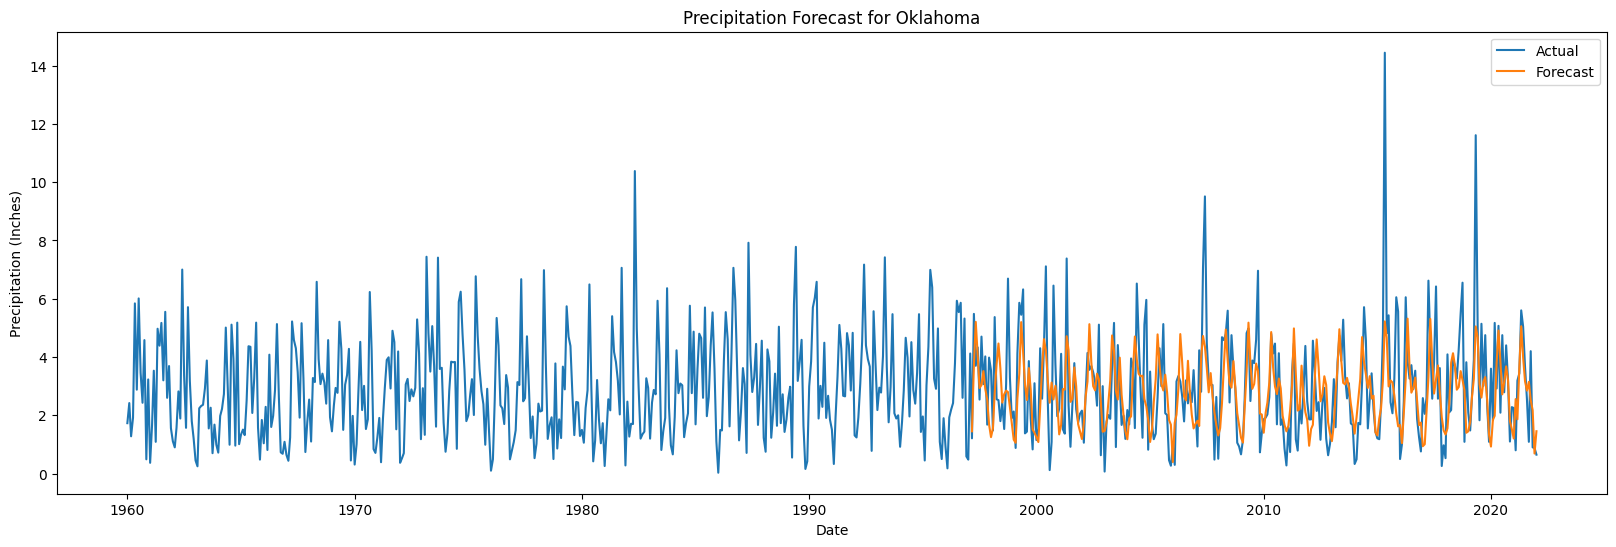

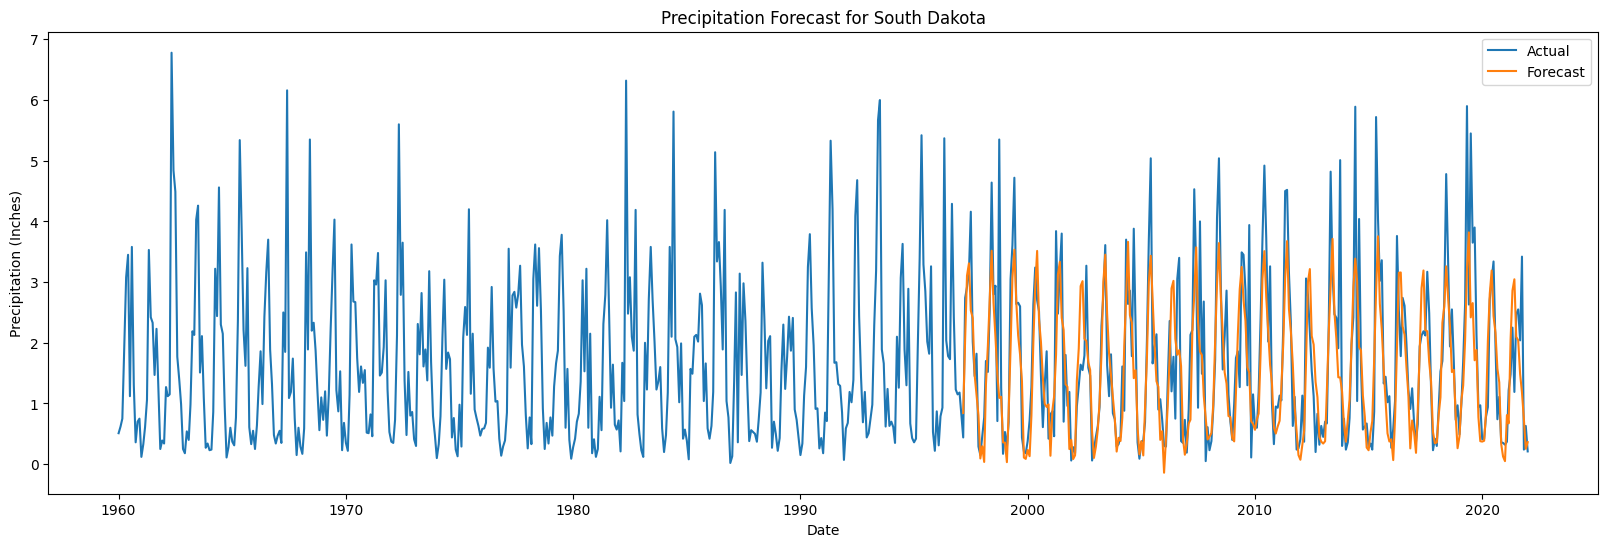

In [31]:
states = df_forecast_pcp['State'].unique()
random_states = random.sample(list(states), 3)
for state in random_states:
    state_df = df_forecast_pcp[df_forecast_pcp['State']==state]
    state_df = state_df.loc[state_df['Date'].dt.year >= 1960]
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Value'], label='Actual')
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Forecast'], label='Forecast')
    ax.set_title(f'Precipitation Forecast for {state}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Precipitation (Inches)')
    ax.legend()
    plt.show()

In [32]:
df_forecast_pcp2 = df_forecast_pcp.copy()

In [33]:

start_date = df_forecast_pcp2['Date'].max().start_time.to_pydatetime()
end_date = start_date + pd.DateOffset(years=10)
date_range = pd.date_range(start=start_date + pd.DateOffset(months=1), end=end_date, freq='MS').strftime('%Y-%m').tolist()
states = df_forecast_pcp2['State'].unique().tolist()
state_dfs = []
for state in states:
    state_df = pd.DataFrame({'Date': date_range, 'State': state})
    state_df['Date'] = pd.to_datetime(state_df['Date'])
    state_dfs.append(state_df)
new_df_pcp = pd.concat(state_dfs, ignore_index=True)
new_df_pcp = pd.merge(new_df_pcp, df_forecast_pcp2, on=['Date', 'State'], how='left')


In [34]:
new_df_pcp['Date'] = pd.to_datetime(new_df_pcp['Date'], format='%Y-%m')
new_df_pcp['Date'] = new_df_pcp['Date'].dt.to_period('M')
df_forecast_pcp2 = pd.concat([df_forecast_pcp2, new_df_pcp], axis=0, join='outer')
df_forecast_pcp2 = df_forecast_pcp2.sort_values(['State', 'Date']).reset_index(drop=True)

In [35]:
df_forecast_pcp2

,Date,Value,Anomaly,State,Year,Month,temp,Forecast
0,1895-01,7.52,2.36,Alabama,1895,01,43.1,NaN
1,1895-02,2.66,-2.55,Alabama,1895,02,37.4,NaN
2,1895-03,7.62,1.46,Alabama,1895,03,54.5,NaN
3,1895-04,3.58,-1.26,Alabama,1895,04,63.4,NaN
4,1895-05,3.78,-0.45,Alabama,1895,05,69.5,NaN
...,...,...,...,...,...,...,...,...
80240,2031-09,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN
80241,2031-10,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN
80242,2031-11,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN
80243,2031-12,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df_forecast_pcp2.set_index('Date', inplace=True)
df_forecast_pcp2['Value'] = pd.to_numeric(df_forecast_pcp2['Value'])
state_dfs = {state: df_forecast_pcp2[df_forecast_pcp2['State']==state].copy() for state in df_forecast_pcp2['State'].unique()}
for state in state_dfs:
    train = state_dfs[state].iloc[:-120] 
    test = state_dfs[state].iloc[-120:]
    test.reset_index(inplace=True)
    test = pd.merge(test[['Date', 'State', 'temp']], df_forecast3[['Date', 'State', 'Forecast']], on=['Date', 'State'])
    test.set_index('Date', inplace=True)
    model = SARIMAX(train['Value'],exog=train['temp'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))
    results = model.fit()
    state_dfs[state]['Forecast_pcp'] = results.predict(start=test.index[0], end=test.index[-1],exog=test['Forecast'])
df_forecast_pcp3 = pd.concat(state_dfs.values())
df_forecast_pcp3.reset_index(inplace=True)
print(df_forecast_pcp3)


C:\Python\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Date  Value  Anomaly    State  Year Month  temp  Forecast  \
0      1895-01   7.52     2.36  Alabama  1895    01  43.1       NaN   
1      1895-02   2.66    -2.55  Alabama  1895    02  37.4       NaN   
2      1895-03   7.62     1.46  Alabama  1895    03  54.5       NaN   
3      1895-04   3.58    -1.26  Alabama  1895    04  63.4       NaN   
4      1895-05   3.78    -0.45  Alabama  1895    05  69.5       NaN   
...        ...    ...      ...      ...   ...   ...   ...       ...   
80240  2031-09    NaN      NaN  Wyoming   NaN   NaN   NaN       NaN   
80241  2031-10    NaN      NaN  Wyoming   NaN   NaN   NaN       NaN   
80242  2031-11    NaN      NaN  Wyoming   NaN   NaN   NaN       NaN   
80243  2031-12    NaN      NaN  Wyoming   NaN   NaN   NaN       NaN   
80244  2032-01    NaN      NaN  Wyoming   NaN   NaN   NaN       NaN   

       Forecast_pcp  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...            

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
df_forecast_pcp3

,Date,Value,Anomaly,State,Year,Month,temp,Forecast,Forecast_pcp
0,1895-01,7.52,2.36,Alabama,1895,01,43.1,NaN,NaN
1,1895-02,2.66,-2.55,Alabama,1895,02,37.4,NaN,NaN
2,1895-03,7.62,1.46,Alabama,1895,03,54.5,NaN,NaN
3,1895-04,3.58,-1.26,Alabama,1895,04,63.4,NaN,NaN
4,1895-05,3.78,-0.45,Alabama,1895,05,69.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...
80240,2031-09,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN,1.084221
80241,2031-10,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN,1.142627
80242,2031-11,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN,0.892138
80243,2031-12,NaN,NaN,Wyoming,NaN,NaN,NaN,NaN,0.901005


In [39]:

forecasts_pcp = pd.concat([df_forecast_pcp, df_forecast_pcp3], axis=0, join='outer')
forecasts_pcp = forecasts_pcp.sort_values(['State', 'Date']).reset_index(drop=True)

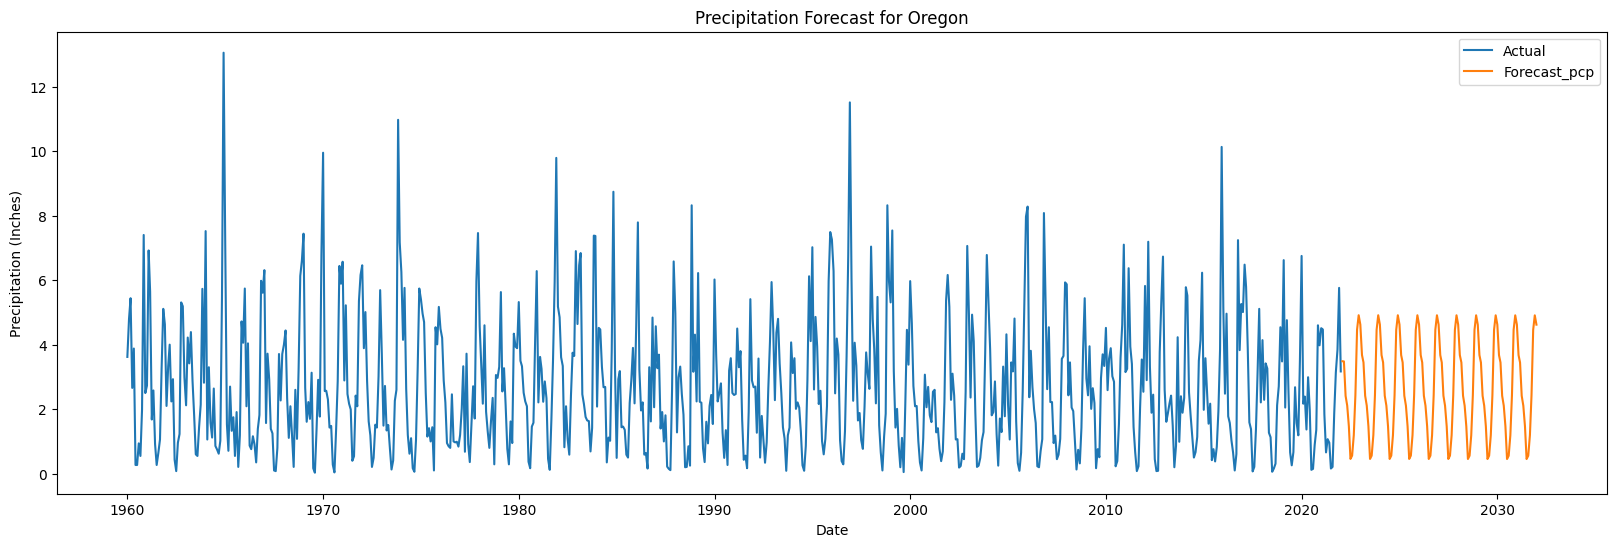

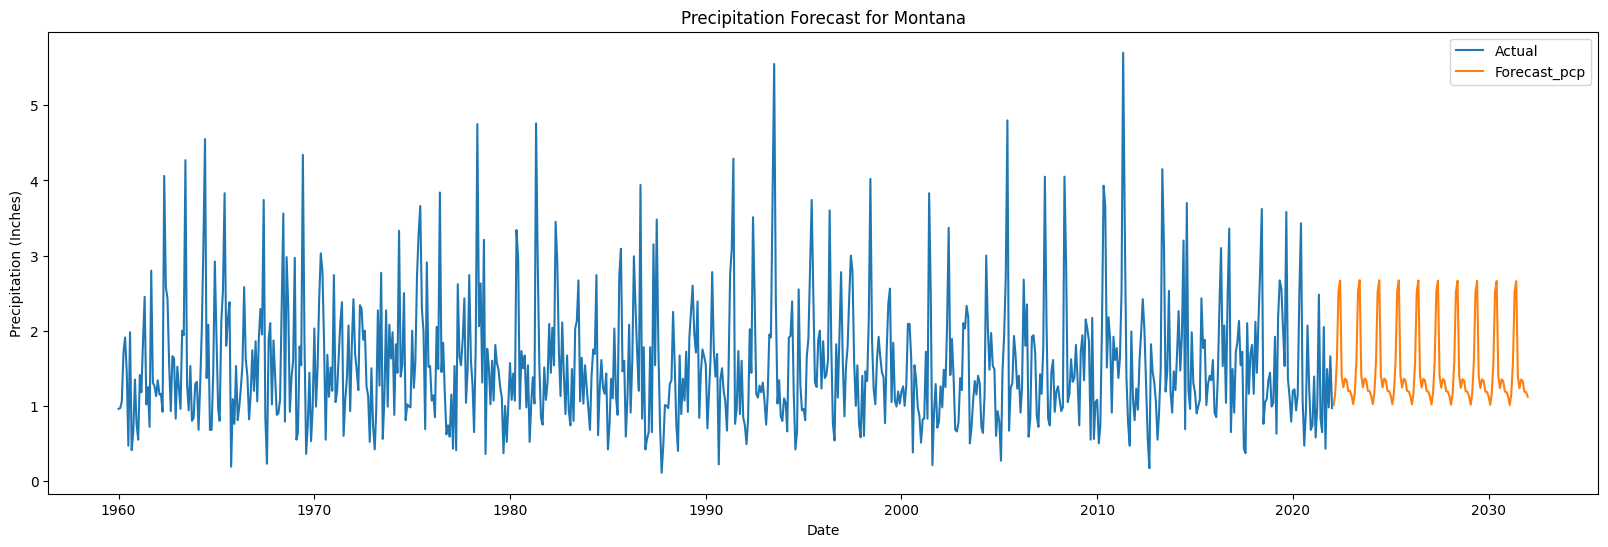

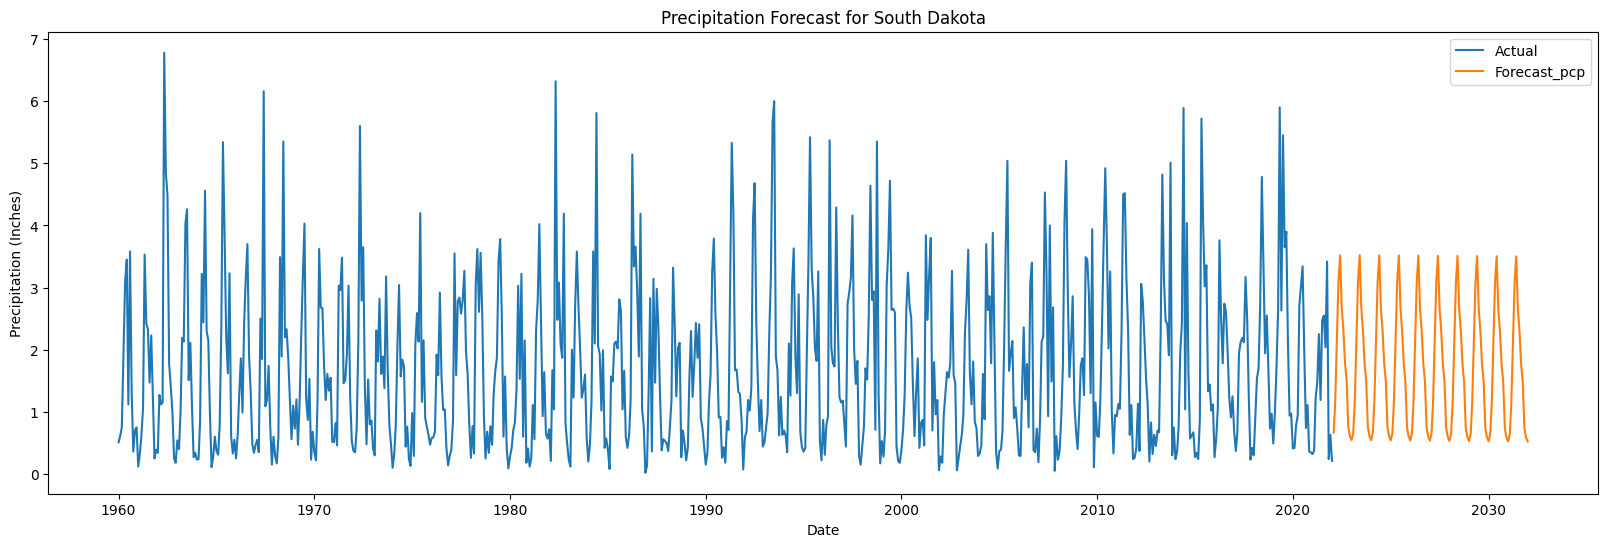

In [40]:
states = forecasts_pcp['State'].unique()
random_states = random.sample(list(states), 3)
for state in random_states:
    state_df = forecasts_pcp[forecasts_pcp['State']==state]
    state_df = state_df.loc[state_df['Date'].dt.year >= 1960] 
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Value'], label='Actual')
    ax.plot(state_df['Date'].dt.to_timestamp(), state_df['Forecast_pcp'], label='Forecast_pcp')
    ax.set_title(f'Precipitation Forecast for {state}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Precipitation (Inches)')
    ax.legend()
    plt.show()

In [41]:
forecasts_pcp1 = forecasts_pcp.copy()

In [42]:
forecasts_pcp1['Date'] = forecasts_pcp1['Date'].dt.to_timestamp()
df_annual_pcp = forecasts_pcp1.groupby('State').resample('Y', on='Date').mean()
df_annual_pcp = df_annual_pcp.reset_index()
df_annual_pcp['Date'] = df_annual_pcp['Date'].dt.year
df_annual_pcp

,State,Date,Value,Anomaly,temp,Forecast,Forecast_pcp
0,Alabama,1895,4.200000,-0.412500,61.641667,NaN,NaN
1,Alabama,1896,3.846667,-0.765833,64.266667,NaN,NaN
2,Alabama,1897,4.030000,-0.582500,64.191667,NaN,NaN
3,Alabama,1898,4.070000,-0.542500,62.983333,NaN,NaN
4,Alabama,1899,4.032500,-0.580000,63.100000,NaN,NaN
...,...,...,...,...,...,...,...
6727,Wyoming,2028,NaN,NaN,NaN,NaN,1.200324
6728,Wyoming,2029,NaN,NaN,NaN,NaN,1.198034
6729,Wyoming,2030,NaN,NaN,NaN,NaN,1.195834
6730,Wyoming,2031,NaN,NaN,NaN,NaN,1.193698


In [43]:
df_annual_pcp

,State,Date,Value,Anomaly,temp,Forecast,Forecast_pcp
0,Alabama,1895,4.200000,-0.412500,61.641667,NaN,NaN
1,Alabama,1896,3.846667,-0.765833,64.266667,NaN,NaN
2,Alabama,1897,4.030000,-0.582500,64.191667,NaN,NaN
3,Alabama,1898,4.070000,-0.542500,62.983333,NaN,NaN
4,Alabama,1899,4.032500,-0.580000,63.100000,NaN,NaN
...,...,...,...,...,...,...,...
6727,Wyoming,2028,NaN,NaN,NaN,NaN,1.200324
6728,Wyoming,2029,NaN,NaN,NaN,NaN,1.198034
6729,Wyoming,2030,NaN,NaN,NaN,NaN,1.195834
6730,Wyoming,2031,NaN,NaN,NaN,NaN,1.193698


In [44]:
df_annual['Value'] = df_annual.groupby(['State', 'Date'])['Value'].fillna(df_annual['Forecast'])
df_annual_pcp['Value'] = df_annual_pcp.groupby(['State', 'Date'])['Value'].fillna(df_annual_pcp['Forecast_pcp'])

In [45]:
Features = pd.merge(df_annual[['State', 'Date', 'Value']], 
                     df_annual_pcp[['State', 'Date', 'Value']], 
                     on=['State', 'Date'], 
                     suffixes=('_temp', '_precipitation'))

In [46]:
Features

,State,Date,Value_temp,Value_precipitation
0,Alabama,1895,61.641667,4.200000
1,Alabama,1896,64.266667,3.846667
2,Alabama,1897,64.191667,4.030000
3,Alabama,1898,62.983333,4.070000
4,Alabama,1899,63.100000,4.032500
...,...,...,...,...
6727,Wyoming,2028,43.031502,1.200324
6728,Wyoming,2029,43.064832,1.198034
6729,Wyoming,2030,43.098161,1.195834
6730,Wyoming,2031,43.131491,1.193698


# Corn Parquet

In [47]:
df = pd.read_parquet('C:\Python\corn.parquet')
df.head()

,SOURCE_DESC,SECTOR_DESC,GROUP_DESC,COMMODITY_DESC,CLASS_DESC,PRODN_PRACTICE_DESC,UTIL_PRACTICE_DESC,STATISTICCAT_DESC,UNIT_DESC,SHORT_DESC,...,LOCATION_DESC,YEAR,FREQ_DESC,BEGIN_CODE,END_CODE,REFERENCE_PERIOD_DESC,WEEK_ENDING,LOAD_TIME,VALUE,CV_%
0,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,IRRIGATED,ALL UTILIZATION PRACTICES,AREA PLANTED,ACRES,"CORN, IRRIGATED - ACRES PLANTED",...,"COLORADO, NORTHWEST AND MOUNTAIN, EAGLE",1980,ANNUAL,0,0,YEAR,NaT,2011-12-31 23:00:00,200,None
1,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,IRRIGATED,ALL UTILIZATION PRACTICES,AREA PLANTED,ACRES,"CORN, IRRIGATED - ACRES PLANTED",...,"COLORADO, NORTHWEST AND MOUNTAIN, GUNNISON",1974,ANNUAL,0,0,YEAR,NaT,2011-12-31 23:00:00,200,None
2,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,IRRIGATED,ALL UTILIZATION PRACTICES,AREA PLANTED,ACRES,"CORN, IRRIGATED - ACRES PLANTED",...,"COLORADO, NORTHWEST AND MOUNTAIN, GUNNISON",1980,ANNUAL,0,0,YEAR,NaT,2011-12-31 23:00:00,300,None
3,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,IRRIGATED,ALL UTILIZATION PRACTICES,AREA PLANTED,ACRES,"CORN, IRRIGATED - ACRES PLANTED",...,"COLORADO, NORTHWEST AND MOUNTAIN, MOFFAT",1974,ANNUAL,0,0,YEAR,NaT,2011-12-31 23:00:00,100,None
4,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,IRRIGATED,ALL UTILIZATION PRACTICES,AREA PLANTED,ACRES,"CORN, IRRIGATED - ACRES PLANTED",...,"COLORADO, NORTHWEST AND MOUNTAIN, RIO BLANCO",1974,ANNUAL,0,0,YEAR,NaT,2011-12-31 23:00:00,100,None


In [48]:

df = df[df['STATISTICCAT_DESC'].isin(['AREA PLANTED', 'ACRES HARVESTED', 'YIELD'])]
df = df[df['AGG_LEVEL_DESC'] == 'STATE']
df = df[df['SHORT_DESC'] == 'CORN - ACRES PLANTED']

df = df[df['REFERENCE_PERIOD_DESC'] == 'YEAR']

df.head(2)

,SOURCE_DESC,SECTOR_DESC,GROUP_DESC,COMMODITY_DESC,CLASS_DESC,PRODN_PRACTICE_DESC,UTIL_PRACTICE_DESC,STATISTICCAT_DESC,UNIT_DESC,SHORT_DESC,...,LOCATION_DESC,YEAR,FREQ_DESC,BEGIN_CODE,END_CODE,REFERENCE_PERIOD_DESC,WEEK_ENDING,LOAD_TIME,VALUE,CV_%
190072,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA PLANTED,ACRES,CORN - ACRES PLANTED,...,ALABAMA,2002,ANNUAL,0,0,YEAR,NaT,2011-12-31 23:00:00,"200,000",None
190073,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA PLANTED,ACRES,CORN - ACRES PLANTED,...,ALABAMA,1997,ANNUAL,0,0,YEAR,NaT,2011-12-31 23:00:00,"280,000",None


In [49]:
df_area_planted = df[df['STATISTICCAT_DESC'] == 'AREA PLANTED']
df_area_planted = df[['STATE_NAME', 'YEAR', 'VALUE', 'UNIT_DESC']]
df_area_planted.head()

,STATE_NAME,YEAR,VALUE,UNIT_DESC
190072,ALABAMA,2002,"200,000",ACRES
190073,ALABAMA,1997,"280,000",ACRES
190074,ALABAMA,1978,"640,000",ACRES
190075,ALABAMA,1987,"300,000",ACRES
190076,ALABAMA,1974,"695,000",ACRES


In [81]:
sorted_df = df_area_planted.sort_values(by=['STATE_NAME', 'YEAR'])
sorted_df

,STATE_NAME,YEAR,VALUE,UNIT_DESC
190156,ALABAMA,1926,"2,660,000",ACRES
190157,ALABAMA,1927,"2,790,000",ACRES
190158,ALABAMA,1928,"2,620,000",ACRES
190126,ALABAMA,1929,"2,660,000",ACRES
190094,ALABAMA,1930,"2,953,000",ACRES
...,...,...,...,...
195795,WYOMING,2018,"95,000",ACRES
195804,WYOMING,2019,"95,000",ACRES
195808,WYOMING,2020,"95,000",ACRES
195815,WYOMING,2021,"95,000",ACRES


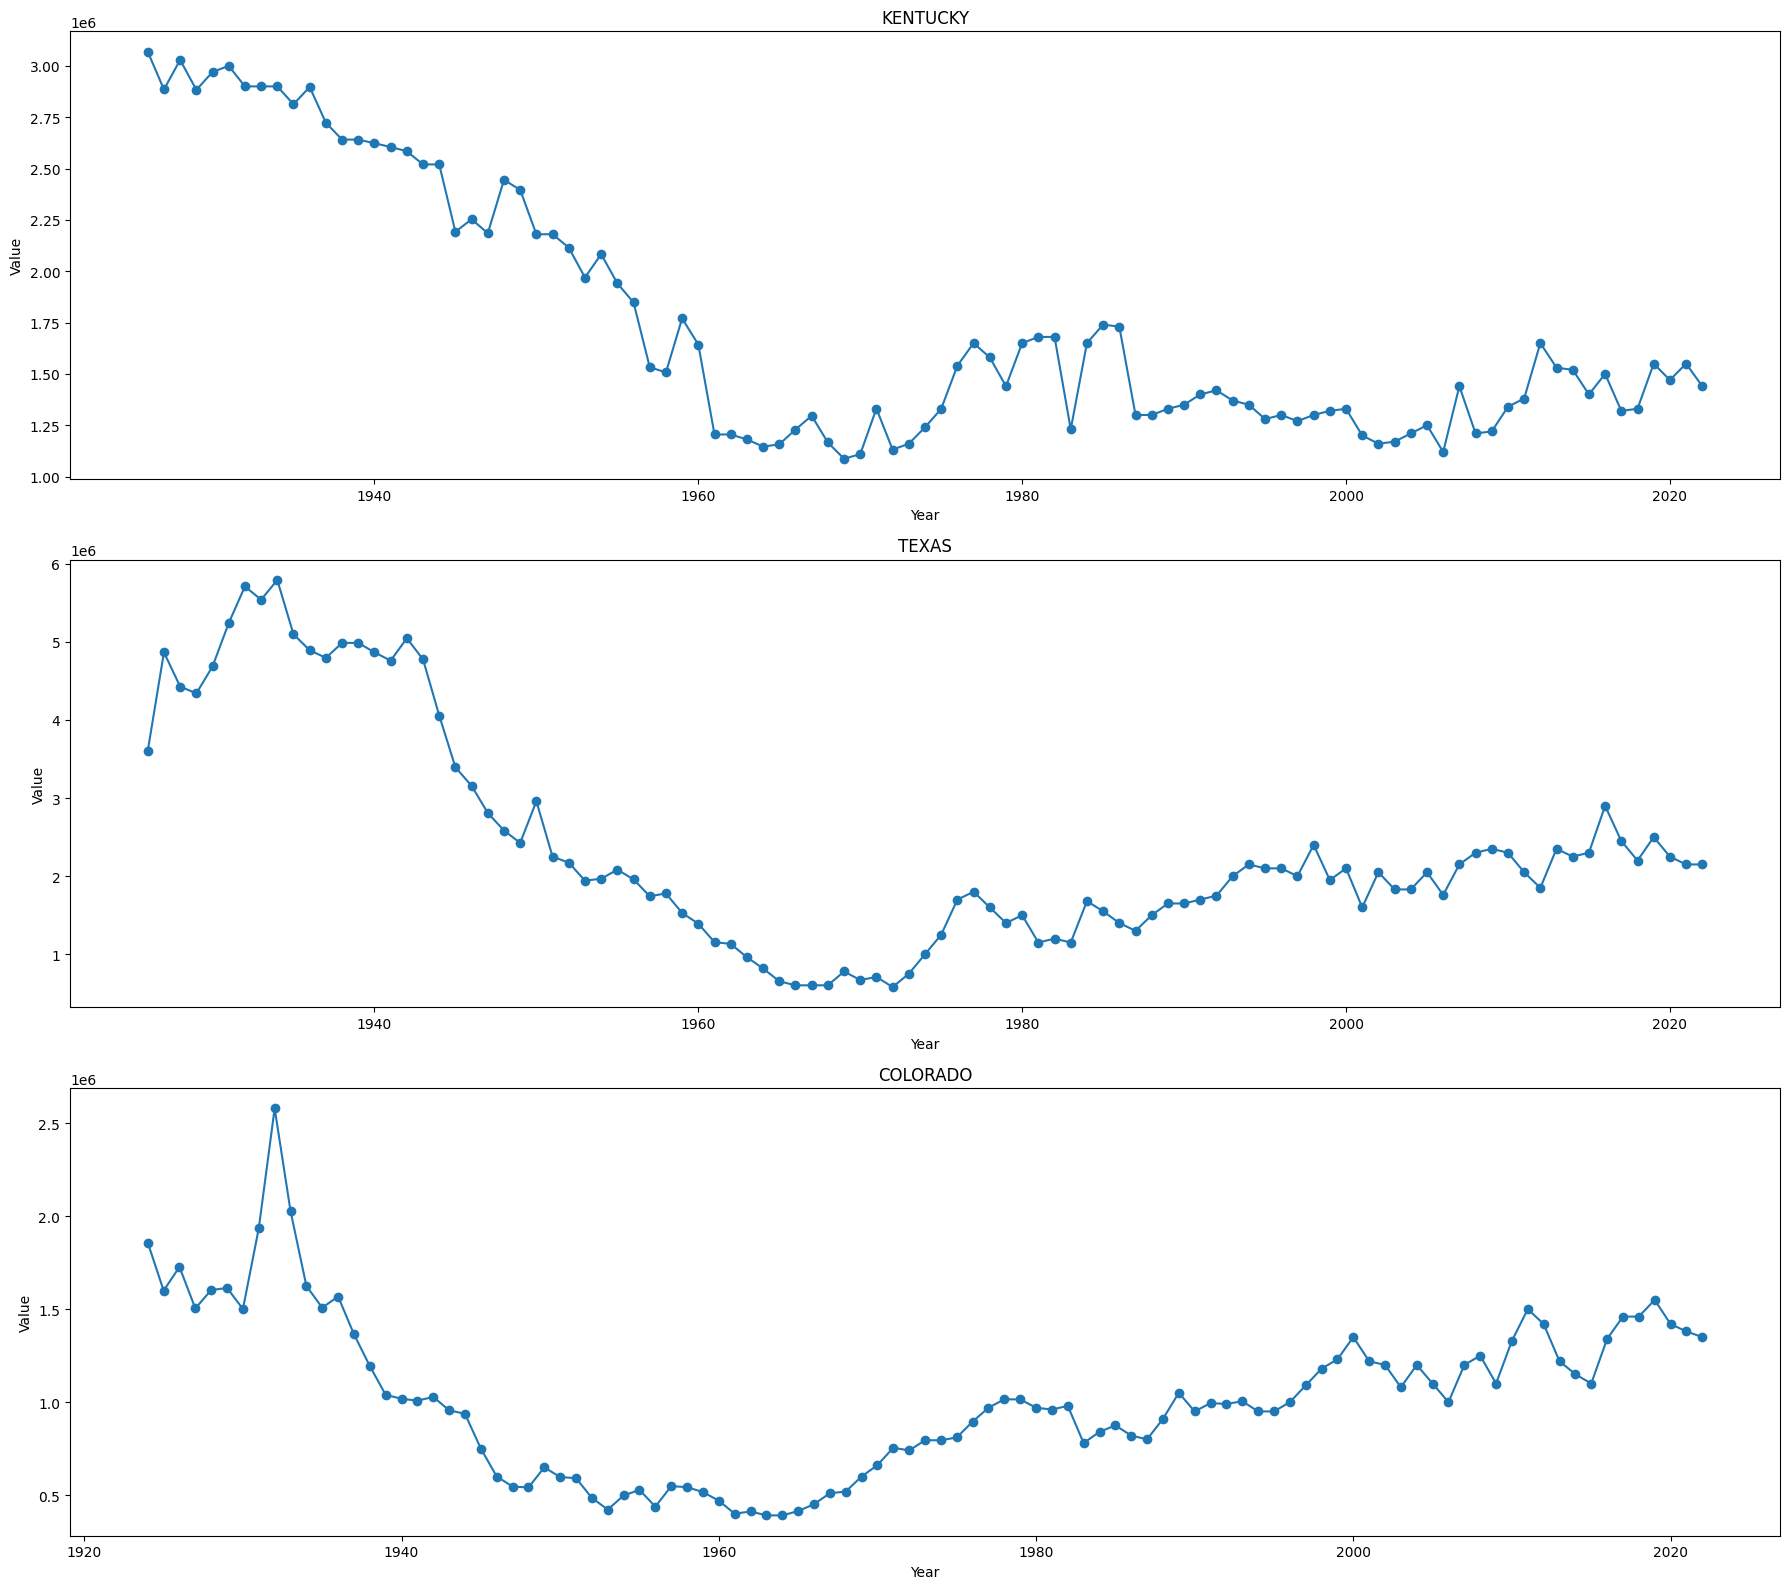

In [83]:
states = np.random.choice(sorted_df['STATE_NAME'].unique(), 3, replace=False)
fig, axs = plt.subplots(3, 1, figsize=(18, 16))
for i, state in enumerate(states):
    state_df = sorted_df[sorted_df['STATE_NAME'] == state]
    axs[i].plot(state_df['YEAR'], state_df['VALUE'].str.replace(',', '').astype(int), marker='o')
    axs[i].set_title(state)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')
plt.tight_layout()
plt.show()

In [52]:
sorted_df = sorted_df.rename(columns={'STATE_NAME': 'State', 'YEAR': 'Date', 'VALUE' : 'Area Planted'})

In [53]:
sorted_df

,State,Date,Area Planted,UNIT_DESC
190156,ALABAMA,1926,"2,660,000",ACRES
190157,ALABAMA,1927,"2,790,000",ACRES
190158,ALABAMA,1928,"2,620,000",ACRES
190126,ALABAMA,1929,"2,660,000",ACRES
190094,ALABAMA,1930,"2,953,000",ACRES
...,...,...,...,...
195795,WYOMING,2018,"95,000",ACRES
195804,WYOMING,2019,"95,000",ACRES
195808,WYOMING,2020,"95,000",ACRES
195815,WYOMING,2021,"95,000",ACRES


In [54]:
sorted_df['State'] = sorted_df['State'].str.lower()
Features['State'] = Features['State'].str.lower()
sorted_df = sorted_df.drop('UNIT_DESC', axis=1)

In [55]:
Features

,State,Date,Value_temp,Value_precipitation
0,alabama,1895,61.641667,4.200000
1,alabama,1896,64.266667,3.846667
2,alabama,1897,64.191667,4.030000
3,alabama,1898,62.983333,4.070000
4,alabama,1899,63.100000,4.032500
...,...,...,...,...
6727,wyoming,2028,43.031502,1.200324
6728,wyoming,2029,43.064832,1.198034
6729,wyoming,2030,43.098161,1.195834
6730,wyoming,2031,43.131491,1.193698


In [56]:
sorted_df['Area Planted'] = pd.to_numeric(sorted_df['Area Planted'].str.replace(',', ''))

In [57]:

sorted_df = sorted_df[sorted_df['Date'] != 2022]

states = sorted_df['State'].unique()
years = list(range(2022, 2033))
df_extended = pd.DataFrame({'State': [], 'Date': [], 'Area Planted': []})
for state in states:
    for year in years:
        df_extended = df_extended.append({'State': state, 'Date': year}, ignore_index=True)
df = pd.concat([sorted_df, df_extended], axis=0)
df['Date'] = df['Date'].astype(int)
df = df.sort_values(['State', 'Date'])
df = df.reset_index(drop=True)
print(df)

        State  Date  Area Planted
0     alabama  1926     2660000.0
1     alabama  1927     2790000.0
2     alabama  1928     2620000.0
3     alabama  1929     2660000.0
4     alabama  1930     2953000.0
...       ...   ...           ...
5137  wyoming  2028           NaN
5138  wyoming  2029           NaN
5139  wyoming  2030           NaN
5140  wyoming  2031           NaN
5141  wyoming  2032           NaN

[5142 rows x 3 columns]


In [58]:
Final = pd.merge(df, Features, on=['Date', 'State'], how='inner')

In [59]:
Final

,State,Date,Area Planted,Value_temp,Value_precipitation
0,alabama,1926,2660000.0,62.900000,4.956667
1,alabama,1927,2790000.0,65.583333,3.910000
2,alabama,1928,2620000.0,62.483333,4.710833
3,alabama,1929,2660000.0,63.433333,6.255833
4,alabama,1930,2953000.0,63.266667,3.816667
...,...,...,...,...,...
5122,wyoming,2028,NaN,43.031502,1.200324
5123,wyoming,2029,NaN,43.064832,1.198034
5124,wyoming,2030,NaN,43.098161,1.195834
5125,wyoming,2031,NaN,43.131491,1.193698


In [60]:
Final.to_csv('Forecast.csv', index=False)

# Without precipitation

In [61]:
final_area_p = pd.read_csv('Forecast.csv')

In [62]:
final_area_p1 = final_area_p[['State','Date','Area Planted','Value_temp']]

In [63]:
final_area_p1 = final_area_p1[final_area_p1['Date'] <= 2021]


In [64]:
final_area_p1

,State,Date,Area Planted,Value_temp
0,alabama,1926,2660000.0,62.900000
1,alabama,1927,2790000.0,65.583333
2,alabama,1928,2620000.0,62.483333
3,alabama,1929,2660000.0,63.433333
4,alabama,1930,2953000.0,63.266667
...,...,...,...,...
5111,wyoming,2017,95000.0,43.200000
5112,wyoming,2018,95000.0,42.408333
5113,wyoming,2019,95000.0,40.275000
5114,wyoming,2020,95000.0,42.775000


In [65]:
final_area_p1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 0 to 5115
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         4599 non-null   object 
 1   Date          4599 non-null   int64  
 2   Area Planted  4599 non-null   float64
 3   Value_temp    4599 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 179.6+ KB


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


In [67]:
final_area_p1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 0 to 5115
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         4599 non-null   object 
 1   Date          4599 non-null   int64  
 2   Area Planted  4599 non-null   float64
 3   Value_temp    4599 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 179.6+ KB


In [88]:
final_area_p2 = final_area_p1[final_area_p1['Date'] >= 2000]

In [89]:
final_area_p2

,State,Date,Area Planted,Value_temp
74,alabama,2000,230000.0,63.566667
75,alabama,2001,180000.0,63.033333
76,alabama,2002,200000.0,63.575000
77,alabama,2003,220000.0,62.733333
78,alabama,2004,220000.0,63.333333
...,...,...,...,...
5111,wyoming,2017,95000.0,43.200000
5112,wyoming,2018,95000.0,42.408333
5113,wyoming,2019,95000.0,40.275000
5114,wyoming,2020,95000.0,42.775000


In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
final_area_p2 = final_area_p2.sort_values(by=['State', 'Date'])
splitter = TimeSeriesSplit(n_splits=5)

for state, data in final_area_p2.groupby('State'):
    for train_idx, test_idx in splitter.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
    model = RandomForestRegressor()
    train_data['lagged_temperature'] = train_data['Value_temp'].shift(1)
    train_data['lagged_temperature'] = train_data['lagged_temperature'].fillna(0)
    test_data['lagged_temperature'] = test_data['Value_temp'].shift(1)
    test_data['lagged_temperature'] = test_data['lagged_temperature'].fillna(0)
    model.fit(train_data[['Date','Value_temp','lagged_temperature']], train_data['Area Planted'])
    test_data['Area Planted Forecast'] = model.predict(test_data[['Date','Value_temp','lagged_temperature']])
    final_area_p2.loc[test_data.index, 'Area Planted Forecast'] = test_data['Area Planted Forecast']
    mae = mean_absolute_error(test_data['Area Planted'], test_data['Area Planted Forecast'])
    mse = mean_squared_error(test_data['Area Planted'], test_data['Area Planted Forecast'])
    rmse = mean_squared_error(test_data['Area Planted'], test_data['Area Planted Forecast'], squared=False)
    r2 = r2_score(test_data['Area Planted'], test_data['Area Planted Forecast'])

    print(f"State: {state}, MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")


State: alabama, MAE: 53216.67, MSE: 3248934166.67, RMSE: 56999.42, R^2: -19.89
State: arizona, MAE: 8930.00, MSE: 110856366.67, RMSE: 10528.84, R^2: -0.53
State: arkansas, MAE: 195000.00, MSE: 48600305000.00, RMSE: 220454.77, R^2: -4.35
State: california, MAE: 47933.33, MSE: 2479246666.67, RMSE: 49792.03, R^2: -1.32
State: colorado, MAE: 119300.00, MSE: 25693936666.67, RMSE: 160293.28, R^2: -3.88
State: connecticut, MAE: 550.00, MSE: 793900.00, RMSE: 891.01, R^2: -2.57
State: delaware, MAE: 5150.00, MSE: 50654166.67, RMSE: 7117.17, R^2: -2.04
State: florida, MAE: 10300.00, MSE: 124695000.00, RMSE: 11166.69, R^2: -21.45
State: georgia, MAE: 80750.00, MSE: 6706289166.67, RMSE: 81891.94, R^2: -4.27
State: idaho, MAE: 45333.33, MSE: 2062746666.67, RMSE: 45417.47, R^2: -91.82
State: illinois, MAE: 567000.00, MSE: 393093666666.67, RMSE: 626971.82, R^2: -2.61
State: indiana, MAE: 218666.67, MSE: 78639500000.00, RMSE: 280427.35, R^2: -1.21
State: iowa, MAE: 240333.33, MSE: 110731000000.00, RMS

In [184]:
final_area_p1 = final_area_p1.sort_values(by=['State', 'Date'])
splitter = TimeSeriesSplit(n_splits=5)

for state, data in final_area_p1.groupby('State'):
    for train_idx, test_idx in splitter.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
    model = RandomForestRegressor()
    train_data['lagged_temperature'] = train_data['Value_temp'].shift(1)
    train_data['lagged_temperature'] = train_data['lagged_temperature'].fillna(0)
    test_data['lagged_temperature'] = test_data['Value_temp'].shift(1)
    test_data['lagged_temperature'] = test_data['lagged_temperature'].fillna(0)
    model.fit(train_data[['Date','Value_temp','lagged_temperature']], train_data['Area Planted'])
    test_data['Area Planted Forecast'] = model.predict(test_data[['Date','Value_temp','lagged_temperature']])
    final_area_p1.loc[test_data.index, 'Area Planted Forecast'] = test_data['Area Planted Forecast']
    mae = mean_absolute_error(test_data['Area Planted'], test_data['Area Planted Forecast'])
    mse = mean_squared_error(test_data['Area Planted'], test_data['Area Planted Forecast'])
    rmse = mean_squared_error(test_data['Area Planted'], test_data['Area Planted Forecast'], squared=False)
    r2 = r2_score(test_data['Area Planted'], test_data['Area Planted Forecast'])

    print(f"State: {state}, MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")


State: alabama, MAE: 77062.50, MSE: 6970712500.00, RMSE: 83490.79, R^2: -3.42
State: arizona, MAE: 18644.71, MSE: 541151517.65, RMSE: 23262.66, R^2: -1.01
State: arkansas, MAE: 331621.88, MSE: 138442118593.75, RMSE: 372078.11, R^2: -3.41
State: california, MAE: 84953.12, MSE: 8941377343.75, RMSE: 94558.86, R^2: -0.06
State: colorado, MAE: 153411.25, MSE: 36997350587.50, RMSE: 192346.95, R^2: -0.47
State: connecticut, MAE: 4790.00, MSE: 25418925.00, RMSE: 5041.72, R^2: -11.71
State: delaware, MAE: 9855.00, MSE: 153157687.50, RMSE: 12375.69, R^2: -1.04
State: florida, MAE: 12100.00, MSE: 256071562.50, RMSE: 16002.24, R^2: -0.15
State: georgia, MAE: 71793.75, MSE: 8937090937.50, RMSE: 94536.19, R^2: -0.73
State: idaho, MAE: 114937.50, MSE: 14482779375.00, RMSE: 120344.42, R^2: -10.70
State: illinois, MAE: 714090.00, MSE: 724498408000.00, RMSE: 851174.72, R^2: -0.40
State: indiana, MAE: 305236.25, MSE: 154418569762.50, RMSE: 392961.28, R^2: -0.14
State: iowa, MAE: 1172606.25, MSE: 17178960

In [ ]:
final_area_p1 = final_area_p1.sort_values(by=['State', 'Date'])
splitter = TimeSeriesSplit(n_splits=5)

for state, data in final_area_p1.groupby('State'):
    for train_idx, test_idx in splitter.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
    train_data['lagged_temperature'] = train_data['Value_temp'].shift(1)
    train_data['lagged_temperature'] = train_data['lagged_temperature'].fillna(0)
    test_data['lagged_temperature'] = test_data['Value_temp'].shift(1)
    test_data['lagged_temperature'] = test_data['lagged_temperature'].fillna(0)    
    # define parameter grid for hyperparameter tuning
    param_grid = {'n_estimators': [50, 100, 150, 200],
                  'max_depth': [5, 10, 15, 20],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4]}
    
    # create random forest regressor model
    model = RandomForestRegressor()
    
    # create grid search object and fit to training data
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(train_data[['Date','Value_temp','lagged_temperature']], train_data['Area Planted'])
    
    # get best estimator and predict on test data
    best_model = grid_search.best_estimator_
    test_data['Area Planted Forecast'] = best_model.predict(test_data[['Date','Value_temp','lagged_temperature']])
    
    # update final_area_p1 with predicted values
    final_area_p1.loc[test_data.index, 'Area Planted Forecast'] = test_data['Area Planted Forecast']
    
    # evaluate model performance
    mae = mean_absolute_error(test_data['Area Planted'], test_data['Area Planted Forecast'])
    mse = mean_squared_error(test_data['Area Planted'], test_data['Area Planted Forecast'])
    rmse = mean_squared_error(test_data['Area Planted'], test_data['Area Planted Forecast'], squared=False)
    r2 = r2_score(test_data['Area Planted'], test_data['Area Planted Forecast'])

    print(f"State: {state}, MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")


In [165]:
final_area_p1

,State,Date,Area Planted,Value_temp,Area Planted Forecast
0,alabama,1926,2660000.0,62.900000,NaN
1,alabama,1927,2790000.0,65.583333,NaN
2,alabama,1928,2620000.0,62.483333,NaN
3,alabama,1929,2660000.0,63.433333,NaN
4,alabama,1930,2953000.0,63.266667,NaN
...,...,...,...,...,...
5111,wyoming,2017,95000.0,43.200000,NaN
5112,wyoming,2018,95000.0,42.408333,NaN
5113,wyoming,2019,95000.0,40.275000,NaN
5114,wyoming,2020,95000.0,42.775000,NaN


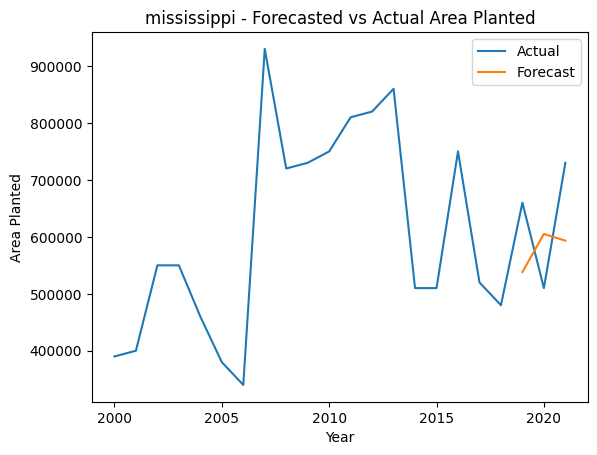

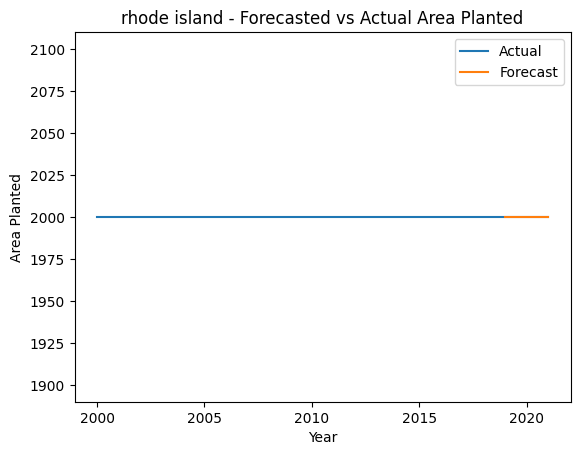

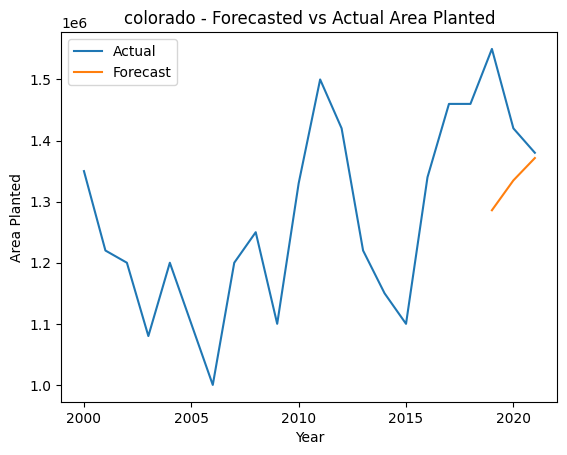

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Choose 3 random states
states = np.random.choice(final_area_p2['State'].unique(), size=3, replace=False)

# Plot the forecasted vs actual values for each state
for state in states:
    data = final_area_p2[final_area_p2['State'] == state]
    plt.plot(data['Date'], data['Area Planted'], label='Actual')
    plt.plot(data['Date'], data['Area Planted Forecast'], label='Forecast')
    plt.title(f"{state} - Forecasted vs Actual Area Planted")
    plt.xlabel("Year")
    plt.ylabel("Area Planted")
    plt.legend()
    plt.show()


In [124]:
test_data

,State,Date,Area Planted,Value_temp,Area Planted Forecast
5100,wyoming,2006,85000.0,43.175000,83850.0
5101,wyoming,2007,95000.0,43.291667,85200.0
5102,wyoming,2008,95000.0,40.683333,97980.0
5103,wyoming,2009,90000.0,40.925000,98090.0
5104,wyoming,2010,90000.0,41.950000,85870.0
5105,wyoming,2011,105000.0,41.058333,87020.0
5106,wyoming,2012,105000.0,44.791667,85250.0
5107,wyoming,2013,100000.0,41.675000,81870.0
5108,wyoming,2014,90000.0,42.125000,86400.0
5109,wyoming,2015,85000.0,44.158333,85250.0


The Area planted forecasting did not work as there is no pattern found in the data. Maybe using monthly data or other features can improve the prediction.